# QBUS6830 Tutorial Lab 12: Forecasting 10 day volatility and 1 day Value at  Risk

## Data
For Q1 in this lab session we will use daily data on BHP returns, from Jan, 2010 to October, 2021. The data can be found in the file `bhp_yf_2000_2021.csv`.

For Q2 we will use data for the All Ordinaries index on the ASX. The file `ao_yf_2009_2021.csv` contains the daily values (open, high, low, close) from January, 2009 to October, 2021.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from scipy.optimize import fmin
from datetime import datetime
import yfinance as yf
import os
from scipy.stats import kurtosis
from statsmodels.tsa.arima.model import ARIMA
from tqdm.notebook import tqdm
from statsmodels.stats.stattools import jarque_bera
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from arch import univariate
import sys

### Q1 (Python and GARCH h=10 step ahead forecasting)

In [24]:
# Download data automatically if file not present
name_bhp = 'bhp_yf_2010_2021.csv'

# BHP
if not os.path.isfile(name_bhp):
    data_bhp = yf.download("BHP.AX", start='2010-01-01', end='2021-10-23')
    data_bhp.to_csv(name_bhp)

In [25]:
data = pd.read_csv(name_bhp, index_col='Date', parse_dates=True, dayfirst=True)
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,39.947372,40.423939,39.909992,40.255737,22.826643,3949861
2010-01-05,40.648205,40.779026,40.395905,40.442627,22.932615,9721826
2010-01-06,40.722958,40.975258,40.685581,40.947224,23.218742,6951354
2010-01-07,41.031322,41.246246,40.881813,40.900501,23.192249,7091269
2010-01-08,40.825748,40.993946,40.648205,40.760338,23.112768,4906718
...,...,...,...,...,...,...
2021-10-18,39.000000,39.189999,38.480000,39.189999,39.189999,7054431
2021-10-19,38.970001,38.980000,38.389999,38.389999,38.389999,6449520
2021-10-20,39.139999,39.279999,38.570000,38.570000,38.570000,7606131


In [26]:
# It is actually not necessary to truncate the return
# series; we do it to speed up the forecasting later.
p = data['Adj Close']
r_all = 100 * np.log(p).diff().dropna()
r = r_all[:'2019-11-04']
r

Date
2010-01-05    0.463174
2010-01-06    1.239967
2010-01-07   -0.114167
2010-01-08   -0.343294
2010-01-11    1.929903
                ...   
2019-10-29    1.236452
2019-10-30   -1.153552
2019-10-31   -0.693001
2019-11-01   -0.697843
2019-11-04    2.161344
Name: Adj Close, Length: 2486, dtype: float64

### (a) Fit the ARCH(5), GARCH, GJR-GARCH, EGARCH, all with Gaussian errors and constant means to the data up to the day of 4/11/19. Report the estimated volatility persistence of each model.

In [27]:
arch5_fit = arch_model(r_all, mean='Constant', vol='ARCH', p=5, dist='Normal').fit( disp="off")
garch11_fit = arch_model(r_all, mean='Constant', vol='GARCH', p=1, q=1, dist='Normal').fit( disp="off")
gjr11_fit = arch_model(r_all, mean='Constant', vol='GARCH', p=1, o=1, q=1, dist='Normal').fit( disp="off")
egarch_fit = arch_model(r_all, mean='Constant', vol='EGARCH', p=1, o=1, q=1, dist='Normal').fit( disp="off")

a15 = arch5_fit.params[2:] #obtain coefficients of a(t-1)^2, .. a(t-5)^2 in ARCH cond. vol equation

a1g = garch11_fit.params['alpha[1]'] #obtain coefficient of a(t-1)^2 in cond. vol equation
b1g = garch11_fit.params['beta[1]'] #obtain coefficient of volatility in GARCH cond. vol equation

a1gj = gjr11_fit.params['alpha[1]'] #obtain coefficient of a(t-1)^2 in cond. vol equation
b1gj = gjr11_fit.params['beta[1]'] #obtain coefficient of volatility in cond. vol equation
g1gj = gjr11_fit.params['gamma[1]'] #obtain coefficient of volatility in cond. vol equation

b1e = egarch_fit.params['beta[1]'] #obtain coefficient of volatility in cond. vol equation

print(sum(a15), a1g+b1g, a1gj+b1gj+g1gj/2, b1e)

0.59300211249002 0.9864882211328588 0.9869567832079704 0.9854123720085018


### Answer guide
The ARCH(5) has volatility persistence $\sum_{i=1}^5 \alpha_i = 0.593$
The GARCH has volatility persistence $\alpha_1+\beta_1 = 0.986$
The GJR-GARCH has volatility persistence $\alpha_1+\beta_1+0.5\gamma = 0.987$
The EGARCH has volatility persistence $\beta_1 = 0.985$

Clearly the ARCH estimates much lower volatility persistenc, whilst the 3 other models estimate very very high persistence, very close to 1. These models suggest very different behavior in volatility reverting to its long-run mean: the ARCH suggest relatively quick reversion, the others suggest very slow reversion. The latter 3 models suggest high (or low) volatility periods will persist for much longer than the ARCH says they will. This could have impacts on 10 day volatility forecasting.

#### (b) After 4/11/2019, generate 10 step-ahead forecasts of volatility for the models: ARCH(5), GARCH, GJR-GARCH, EGARCH, all with Gaussian errors and constant means; plus the RM model. Update the forecast origin for each forecast, until the end of the forecast sample. Re-estimate the parameter estimates every 100 days. Also include the HS25, HS100 and HS-T methods. Plot these forecasts, parametric and HS in separate plots, and comment on their apparent forecast accuracy.  (this took 5 mins on my laptop)

In [8]:
n_fore = len(r_all) - len(r) - 9
farch5_10 = pd.Series(index=r_all[-n_fore:].index, dtype='float64')
fgarch11_10 = pd.Series(index=r_all[-n_fore:].index, dtype='float64')
fgjr11_10 = pd.Series(index=r_all[-n_fore:].index, dtype='float64')
fegarch_10 = pd.Series(index=r_all[-n_fore:].index, dtype='float64')
frm_10 = pd.Series(index=r_all[-n_fore:].index, dtype='float64')
fs2_T_10 = pd.Series(index=r_all[-n_fore:].index, dtype='float64')
fs2_100_10 = pd.Series(index=r_all[-n_fore:].index, dtype='float64')
fs2_25_10 = pd.Series(index=r_all[-n_fore:].index, dtype='float64')

# Re-instantiate the model objects with full data
arch5_all = arch_model(r_all, mean='Constant', vol='ARCH', p=5, dist='Normal')
garch11_all = arch_model(r_all, mean='Constant', vol='GARCH', p=1, q=1, dist='Normal')
gjr11_all = arch_model(r_all, mean='Constant', vol='GARCH', p=1, o=1, q=1, dist='Normal')
egarch_all = arch_model(r_all, mean='Constant', vol='EGARCH', p=1, o=1, q=1, dist='Normal')
rm_all = arch_model(r_all, mean='Zero', vol='GARCH', p=1, q=1, dist='Normal')

n_wind = len(r)
for i in tqdm(range(n_fore)):
    if i % 100 == 0:
        arch5_all_fit = arch5_all.fit(first_obs=i, last_obs=i + n_wind, disp="off")
        garch11_all_fit = garch11_all.fit(first_obs=i, last_obs=i + n_wind, disp="off")
        gjr11_all_fit = gjr11_all.fit(first_obs=i, last_obs=i + n_wind, disp="off")
        egarch_all_fit = egarch_all.fit(first_obs=i, last_obs=i + n_wind, disp="off")
        rm_all_fit = rm_all.fit(first_obs=i, last_obs=i + n_wind, disp="off")
    
    # ARCH(5)
    temp = arch5_all_fit.forecast(horizon=10, align='target', reindex=False).variance
    farch5_10[i] = temp.loc[farch5_10.index[i]]['h.10']
    
    # GARCH(1, 1)
    temp = garch11_all_fit.forecast(horizon=10, align='target', reindex=False).variance
    fgarch11_10[i] = temp.loc[fgarch11_10.index[i]]['h.10']
    
    # GJR-GARCH(1, 1)
    temp = gjr11_all_fit.forecast(horizon=10, align='target', reindex=False).variance
    fgjr11_10[i] = temp.loc[fgjr11_10.index[i]]['h.10']
    
    # EGARCH
    temp = egarch_all_fit.forecast(horizon=10, method='simulation', simulations=1000, 
                                   align='target', reindex=False).variance
    fegarch_10[i] = temp.loc[fegarch_10.index[i]]['h.10']
    
    # Risk-Metric
    temp = rm_all_fit.forecast(horizon=10, align='target', reindex=False).variance
    frm_10[i] = temp.loc[frm_10.index[i]]['h.10']
    
    # Ad-hoc methods
    fs2_T_10[i] = r_all[:(i + n_wind)].var()
    fs2_100_10[i] = r_all[(i + n_wind - 100):(i + n_wind)].var()
    fs2_25_10[i] = r_all[(i + n_wind - 25):(i + n_wind)].var()

  0%|          | 0/491 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
# Volatility proxies
rng = 100 * (np.log(data['High']) - np.log(data['Low']))[1:]
rng[rng <= 0] = np.mean([0, np.min(rng[rng > 0])])
ovn = 100 * (np.log(data['Open']) - np.log(data['Close']).shift(1)).dropna()

proxy1 = (r_all - r_all.mean()) ** 2
proxy2 = 0.3607 * rng ** 2
proxy3 = 1.107 * proxy2 + 0.68 * ovn ** 2
proxy4 = np.exp(2 * np.log(rng) - 0.86 + 2 * 0.29 ** 2)

# ten trading days ahead of forst origin, to coincide with the 10 day forecast from origin (4/11/19)
f_proxy1 = proxy1['2019-11-16':]
f_proxy2 = proxy2['2019-11-16':]
f_proxy3 = proxy3['2019-11-16':]
f_proxy4 = proxy4['2019-11-16':]

len(f_proxy1)

491

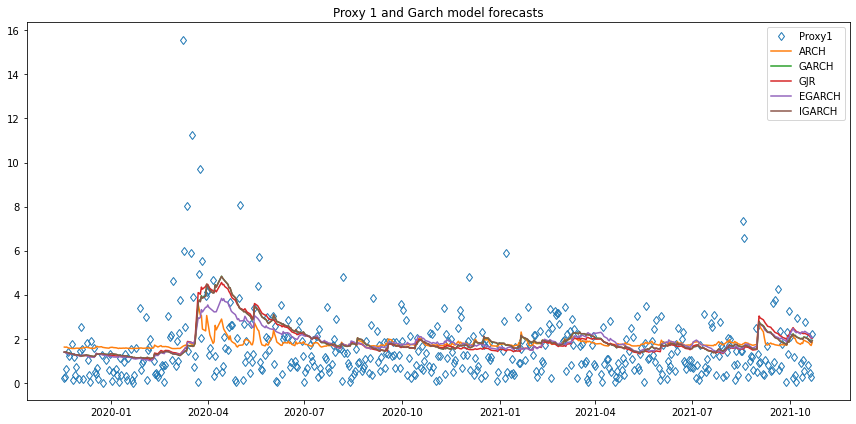

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(np.sqrt(f_proxy1), 'd', mfc='none', label='Proxy1')
plt.plot(np.sqrt(farch5_10), label='ARCH')
plt.plot(np.sqrt(fgarch11_10), label='GARCH')
plt.plot(np.sqrt(fgjr11_10), label='GJR')
plt.plot(np.sqrt(fegarch_10), label='EGARCH')
plt.plot(np.sqrt(frm_10), label='IGARCH')
plt.title('Proxy 1 and Garch model forecasts')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

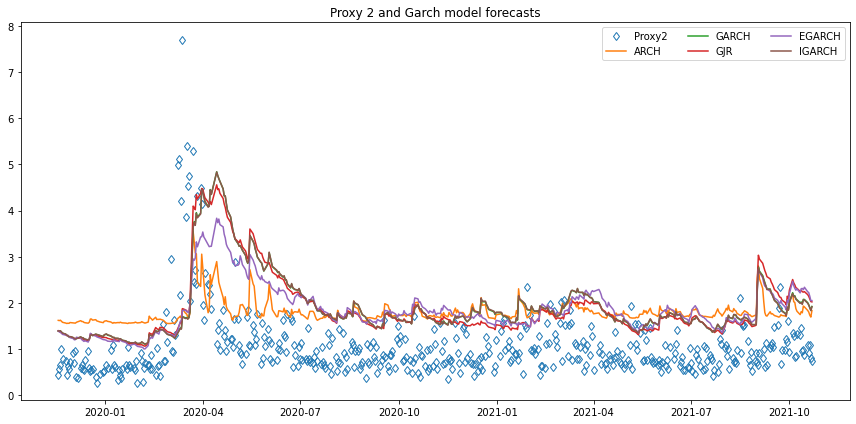

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(np.sqrt(f_proxy2), 'd', mfc='none', label='Proxy2')
plt.plot(np.sqrt(farch5_10), label='ARCH')
plt.plot(np.sqrt(fgarch11_10), label='GARCH')
plt.plot(np.sqrt(fgjr11_10), label='GJR')
plt.plot(np.sqrt(fegarch_10), label='EGARCH')
plt.plot(np.sqrt(frm_10), label='IGARCH')
plt.title('Proxy 2 and Garch model forecasts')
plt.legend(fontsize=10, ncol=3)
plt.tight_layout()
plt.show()

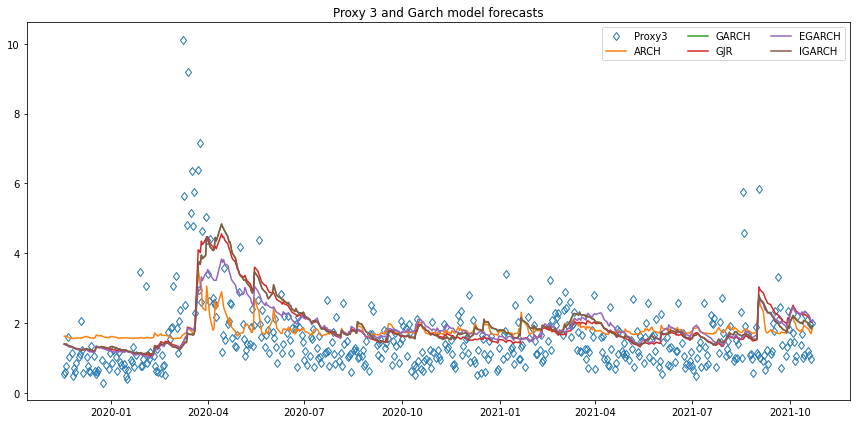

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(np.sqrt(f_proxy3), 'd', mfc='none', label='Proxy3')
plt.plot(np.sqrt(farch5_10), label='ARCH')
plt.plot(np.sqrt(fgarch11_10), label='GARCH')
plt.plot(np.sqrt(fgjr11_10), label='GJR')
plt.plot(np.sqrt(fegarch_10), label='EGARCH')
plt.plot(np.sqrt(frm_10), label='IGARCH')
plt.title('Proxy 3 and Garch model forecasts')
plt.legend(fontsize=10, ncol=3)
plt.tight_layout()
plt.show()

### Answer guide
The parametric GARCH models all react fairly strongly to the start of Covid in early 2020, in their 10-day-ahead forecasts, except for the ARCH model. This model's lower estimated volatility persistence means that the initial effect of the higher volatility has died out 10 days later, with the volatility forecasts reverting to be closer to the long run variance estimated by the ARCH model, after 10 days. The ARCH model appears more accurate for proxies 1 and 3 during this period. 

The GARCH, GJR and RM model forecasts, on the other hand, take a much longer time to recover from the high volatility period. The EGARCH model sits between the ARCH and these 3 latter models in its 10 day forecast recivery after Covid hit. At most other times all the model are quite similar, sitting near to "the top" of the proxy data for each proxy. 

Below we see the usual behavior of the HS methods, taking 25 or 100 days to recover from high volatility periods, or barely reacting at all (HS-T). These methods seem comparatively innaccurate during this period. However, HS-T does seem quite accurate outside of high volatility periods. 

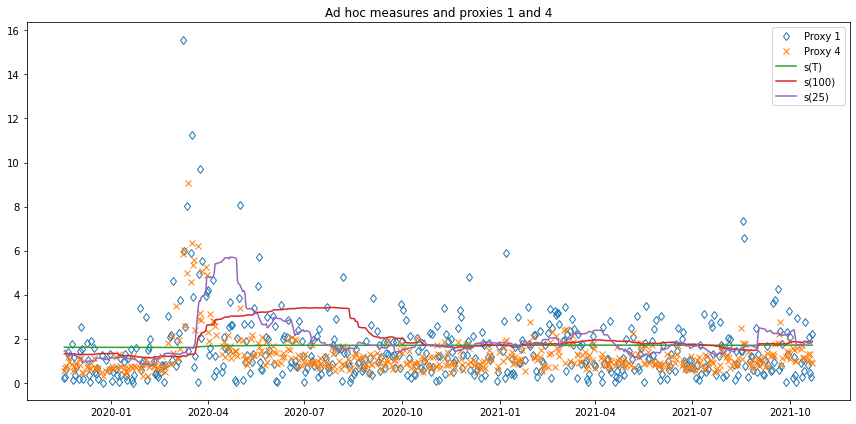

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(np.sqrt(f_proxy1), 'd', mfc='none', label='Proxy 1')
plt.plot(np.sqrt(f_proxy4), 'x', mfc='none', label='Proxy 4')
plt.plot(np.sqrt(fs2_T_10), label='s(T)')
plt.plot(np.sqrt(fs2_100_10), label='s(100)')
plt.plot(np.sqrt(fs2_25_10), label='s(25)')
plt.title('Ad hoc measures and proxies 1 and 4')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

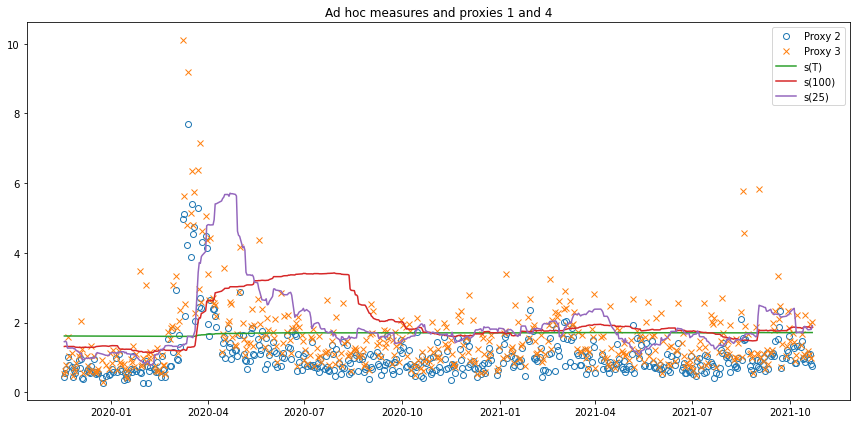

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(np.sqrt(f_proxy2), 'o', mfc='none', label='Proxy 2')
plt.plot(np.sqrt(f_proxy3), 'x', mfc='none', label='Proxy 3')
plt.plot(np.sqrt(fs2_T_10), label='s(T)')
plt.plot(np.sqrt(fs2_100_10), label='s(100)')
plt.plot(np.sqrt(fs2_25_10), label='s(25)')
plt.title('Ad hoc measures and proxies 1 and 4')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

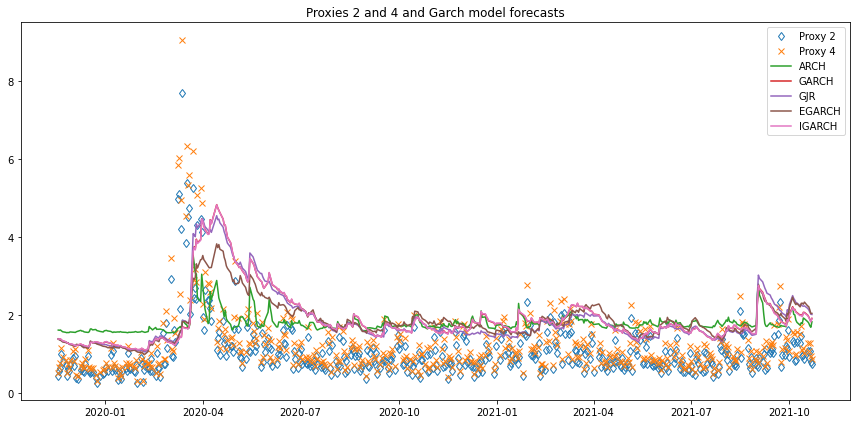

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(np.sqrt(f_proxy2), 'd', mfc='none', label='Proxy 2')
plt.plot(np.sqrt(f_proxy4), 'x', label='Proxy 4')
plt.plot(np.sqrt(farch5_10), label='ARCH')
plt.plot(np.sqrt(fgarch11_10), label='GARCH')
plt.plot(np.sqrt(fgjr11_10), label='GJR')
plt.plot(np.sqrt(fegarch_10), label='EGARCH')
plt.plot(np.sqrt(frm_10), label='IGARCH')
plt.title('Proxies 2 and 4 and Garch model forecasts')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

#### (f) Assess the accuracy of each model's forecasts using volatility proxies 1, 2 and 3. Which models did best overall? Did the proxies agree on which were the best models?

In [16]:
f_model = np.vstack([farch5_10, fgarch11_10, fgjr11_10, fegarch_10, frm_10, fs2_T_10, fs2_100_10, fs2_25_10]).T
f_proxy = np.vstack([f_proxy1, f_proxy2, f_proxy3, f_proxy4]).T
f_model = np.sqrt(f_model)
f_proxy = np.sqrt(f_proxy)
n_model = f_model.shape[1]
n_proxy = f_proxy.shape[1]
f_model_rep = f_model.repeat(n_proxy, axis=1)
f_proxy_rep = np.tile(f_proxy, [1, n_model])
rmse = np.sqrt(np.mean((f_model_rep - f_proxy_rep) ** 2, axis=0))
rmse = rmse.reshape(n_model, -1)
mad = np.mean(np.absolute(f_model_rep - f_proxy_rep), axis=0)
mad = mad.reshape(n_model, -1)

In [17]:
mdl_name = ['ARCH', 'GARCH', 'GJR', 'EGARCH', 'IGARCH', 's(T)', 's(100)', 's(25)']
prx_name = ['Proxy 1', 'Proxy 2', 'Proxy 3', 'Proxy 4']
tbl_rmse = pd.DataFrame(rmse, index=mdl_name, columns=prx_name)
tbl_rmse.round(4)

,Proxy 1,Proxy 2,Proxy 3,Proxy 4
ARCH,1.5064,1.0230,1.0430,1.0036
GARCH,1.5982,1.1964,1.1438,1.1447
GJR,1.5850,1.1668,1.1199,1.1150
EGARCH,1.5484,1.1014,1.0861,1.0640
IGARCH,1.5985,1.1974,1.1448,1.1460
s(T),1.5145,0.9826,1.0872,0.9961
s(100),1.6895,1.3491,1.3061,1.3129
s(25),1.6866,1.3193,1.2617,1.2657


In [18]:
tbl_mad = pd.DataFrame(mad, index=mdl_name, columns=prx_name)
tbl_mad.round(4)

,Proxy 1,Proxy 2,Proxy 3,Proxy 4
ARCH,1.0609,0.8989,0.7265,0.7977
GARCH,1.1138,0.9922,0.7970,0.8812
GJR,1.1015,0.9561,0.7753,0.8530
EGARCH,1.0832,0.9403,0.7521,0.8357
IGARCH,1.1143,0.9935,0.7979,0.8822
s(T),1.0358,0.8312,0.7175,0.7510
s(100),1.2058,1.1120,0.9236,1.0115
s(25),1.1533,1.0154,0.8388,0.9107


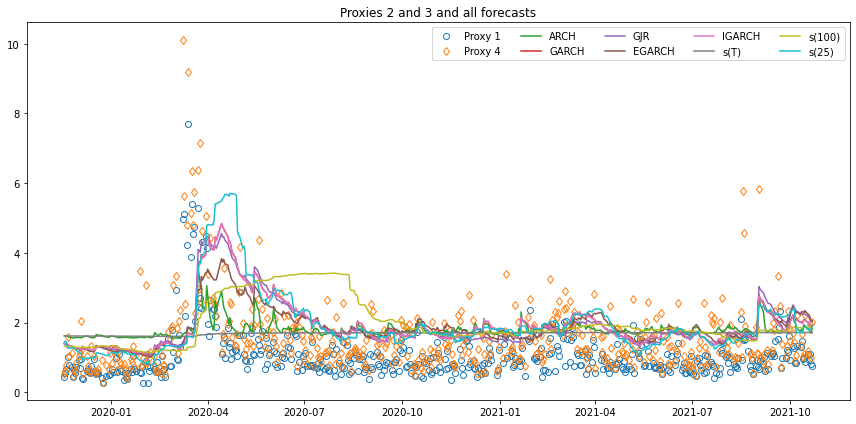

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(np.sqrt(f_proxy2), 'o', mfc='none', label='Proxy 1')
plt.plot(np.sqrt(f_proxy3), 'd', mfc='none', label='Proxy 4')
plt.plot(np.sqrt(farch5_10), label='ARCH')
plt.plot(np.sqrt(fgarch11_10), label='GARCH')
plt.plot(np.sqrt(fgjr11_10), label='GJR')
plt.plot(np.sqrt(fegarch_10), label='EGARCH')
plt.plot(np.sqrt(frm_10), label='IGARCH')
plt.plot(np.sqrt(fs2_T_10), label='s(T)')
plt.plot(np.sqrt(fs2_100_10), label='s(100)')
plt.plot(np.sqrt(fs2_25_10), label='s(25)')
plt.title('Proxies 2 and 3 and all forecasts')
plt.legend(fontsize=10, ncol=5)
plt.tight_layout()
plt.show()

In [20]:
from scipy.stats import rankdata
rk_rmse1 = rankdata(rmse[:,0])
rk_rmse2 = rankdata(rmse[:,1])
rk_rmse3 = rankdata(rmse[:,2])
rk_rmse4 = rankdata(rmse[:,3])
print('ARCH', 'GARCH', 'GJR', 'EGARCH', 'IGARCH', 's(T)', 's(100)', 's(25)')
(rk_rmse4+rk_rmse3+rk_rmse2+rk_rmse1)/4

ARCH GARCH GJR EGARCH IGARCH s(T) s(100) s(25)


array([1.5 , 5.  , 4.  , 2.75, 6.  , 1.75, 8.  , 7.  ])

In [21]:
rk_mad1 = rankdata(mad[:,0])
rk_mad2 = rankdata(mad[:,1])
rk_mad3 = rankdata(mad[:,2])
rk_mad4 = rankdata(mad[:,3])
print('ARCH', 'GARCH', 'GJR', 'EGARCH', 'IGARCH', 's(T)', 's(100)', 's(25)')
(rk_mad4+rk_mad3+rk_mad2+rk_mad1)/4

ARCH GARCH GJR EGARCH IGARCH s(T) s(100) s(25)


array([2., 5., 4., 3., 6., 1., 8., 7.])

In [22]:
rk_rmse1, rk_rmse2, rk_rmse3, rk_rmse4

(array([1., 5., 4., 3., 6., 2., 8., 7.]),
 array([2., 5., 4., 3., 6., 1., 8., 7.]),
 array([1., 5., 4., 2., 6., 3., 8., 7.]),
 array([2., 5., 4., 3., 6., 1., 8., 7.]))

In [23]:
rk_mad1, rk_mad2, rk_mad3, rk_mad4

(array([2., 5., 4., 3., 6., 1., 8., 7.]),
 array([2., 5., 4., 3., 6., 1., 8., 7.]),
 array([2., 5., 4., 3., 6., 1., 8., 7.]),
 array([2., 5., 4., 3., 6., 1., 8., 7.]))

#### Answer guide
Under RMSE, the HS-T and ARCH(5) models were most accurate. The ARCH model ranked 1st or 2nd for each proxy, whilst the HS-T method ranked in the top 3 for each proxy. By average rank, the ARCH(5) model was marginally better. 
Under MAD, remarkably the rank order of the models was exactly the same under all proxies: HS-T then ARCH ranked 1 and 2 each time. Thus, HS-T is preferred under MAD. 

HS-100 and HS-25 always ranked in the bottom 2 places (7 and 8) under both measures: they are the least accurate 10-day volatility forecasters in this period for BHP.

The EGARCH model almost always ranked 3rd under both measures, while GJR and GARCH always ranked 4th and 5th respectively and RM always ranked 6th. 

The ARCH and HS-T models both had the smallest reactions to the Covid hitting and the subsequent high volatility period, in their 10-day volatility forecasts. The ARCH did this by estimating a smaller persistence than other GARCH models, whilst the HS-T did it by using the sample variance of all the sample size T, being not strongly affected by a small number of more extreme returns as T is high.  

### Q2 (VaR forecasting, h = 1) 
#### The file `ao_yf_2009_2021.csv` contains the daily values (open, high, low, close) for the All Ordinaries index on the ASX from January, 2009 to July, 2021.

In [5]:
# Download AORD data if needed
name_ao = 'ao_yf_2009_2021.csv'
if not os.path.isfile(name_ao):
    data_ao = yf.download("^AORD", start='2009-01-01', end='2021-10-23')
    data_ao.to_csv(name_ao)

data_ao = pd.read_csv(name_ao, index_col='Date', parse_dates=True, dayfirst=True)
r_ao = 100 * np.log(data_ao['Adj Close']).diff().dropna()
r_ao

Date
2009-01-05   -0.460617
2009-01-06    1.372821
2009-01-07    1.051591
2009-01-08   -2.295330
2009-01-09    1.004918
                ...   
2021-10-18    0.201772
2021-10-19    0.006502
2021-10-20    0.479978
2021-10-21    0.016820
2021-10-22   -0.022001
Name: Adj Close, Length: 3237, dtype: float64

### (a) plot the AORD index and percentage log return data. Describe the genetral features of each. 

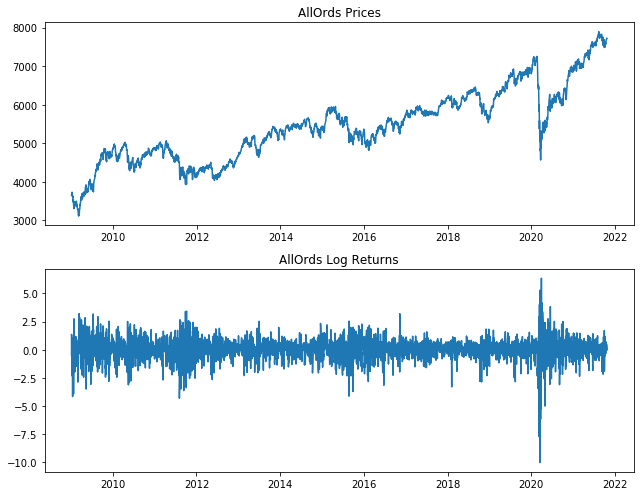

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(9, 7))
ax[0].plot(data_ao['Adj Close'])
ax[0].set_title('AllOrds Prices')
ax[1].plot(r_ao)
ax[1].set_title('AllOrds Log Returns')
plt.tight_layout()
plt.show()

#### Answer guide
CBA prices have had a long, slow upward trend since 2009, except for a sharp drop in early 2020, after which the upward trend is even steeper than before. CBA has had medium (2009-2012; 2015-2017; mid-2020 to now) and low volatility periods (e.g. 2012-2015, 2017-early 2020). 

### (b) Leaving out the last 1000 days as the forecast period, fit the GARCH-t and EGARCH-t models, with constant means, to the in-sample returns. Plot the in-sample 2.5% and 1% VaR estimates for each model and compare. 

In [29]:
# Last day of in-sample period
last_in = '2017-11-09'

# First day of forecasting period
frst_fc = '2017-11-10'

len(r_ao['2017-11-10':])

# Leave out last 1000 days for forecasting

1000

In [30]:
# In-sample fit: GARCH
garch_t_fit = arch_model(r_ao[:last_in], mean='Constant', vol='GARCH', 
                         p=1, q=1, dist='StudentsT').fit(disp="off")

egarch_t_fit = arch_model(r_ao[:last_in], mean='Constant', vol='EGARCH', 
                          p=1, o=1, q=1, dist='StudentsT').fit(disp="off")

In [31]:
# For VaR calculations under Gaussian and Standardised-t distributions
def qn(p):
    return stats.norm.ppf(p)

def qt(p, df):
    return stats.t.ppf(p, df) * np.sqrt((df - 2) / df)

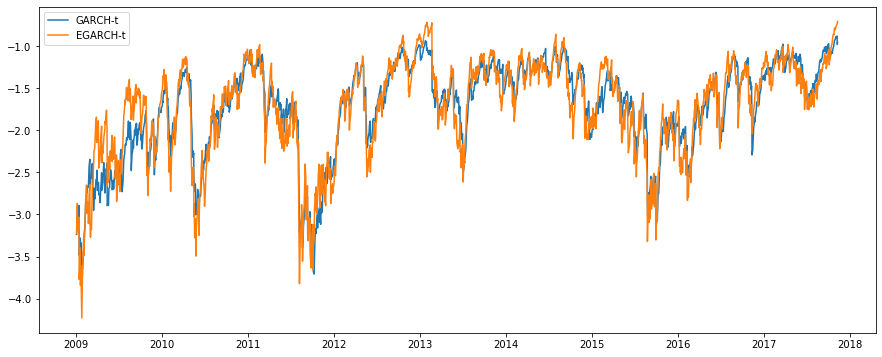

In [33]:
var25_gt = garch_t_fit.params['mu'] + garch_t_fit.conditional_volatility * qt(0.025, garch_t_fit.params['nu'])
var25_egt = egarch_t_fit.params['mu'] + egarch_t_fit.conditional_volatility * qt(0.025, egarch_t_fit.params['nu'])

plt.figure(figsize=(15, 6))

plt.plot(var25_gt, label='GARCH-t')
plt.plot(var25_egt, label='EGARCH-t')

plt.legend()

plt.show()

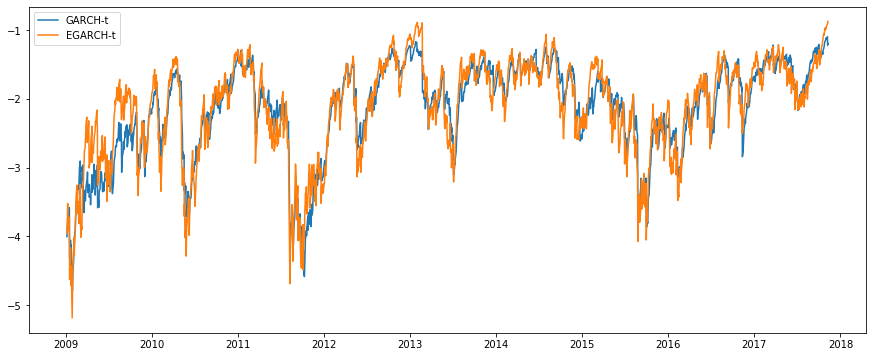

In [34]:
var1_gt = garch_t_fit.params['mu'] + garch_t_fit.conditional_volatility * qt(0.01, garch_t_fit.params['nu'])
var1_egt = egarch_t_fit.params['mu'] + egarch_t_fit.conditional_volatility * qt(0.01, egarch_t_fit.params['nu'])

plt.figure(figsize=(15, 6))

plt.plot(var1_gt, label='GARCH-t')
plt.plot(var1_egt, label='EGARCH-t')

plt.legend()

plt.show()

### Answer guide
The in-sample VaR series seem very similar to each other for both 2.5% and 1% risk levels. The GARCH (blue) is occasionally more extreme than the EGARCH, e.g. in 2009-2010, and then briefly in 2013 and 2015 and 2016.

#### (b) Estimate the symmetric absolute value CAViaR model, again leaving out the last 1000 days. Report the fitted model for p=0.025, 0.01. Interpret the parameters. Plot the in-sample 2.5% and 1% VaR estimates for the CaViaR model and compare it to the previous models. 

In [35]:
'''
CaViaR loss function
More efficient than qregCaViaR
b: vector of model parameters.
r: vector of returns.
p: scalar, indicating probability level.
q0: scalar, initial quantile.
returns: scalar, loss function value.
'''

def caviar_loss(b, r, p, q0):
    n = len(r)
    q = np.empty(n)
    q[0] = q0
    for t in range(1, n):
        q[t] = b[0] + b[1] * q[t - 1] + b[2] * np.abs(r[t - 1])
    
    x1 = r[r > q]
    x2 = r[r < q]
    f1 = q[r > q]
    f2 = q[r < q]
    return p * np.sum(x1 - f1) + (1 - p) * np.sum(f2 - x2)

def caviar_est(b, r, p, q0):
    n = len(r)
    q = np.empty(n)
    q[0] = q0
    for t in range(1, n):
        q[t] = b[0] + b[1] * q[t - 1] + b[2] * np.abs(r[t - 1])
        
    return q    

# Test
q0 = np.quantile(r_ao[:last_in], 0.01, interpolation='midpoint')
caviar_loss([-0.01, 0.8, -0.4], r_ao[:last_in], 0.01, q0)

106.68508874421856

In [36]:
'''
CaViaR update function
b: vector of model parameters.
r: vector of returns.
p: scalar, indicating probability level.
q0: scalar, initial quantile.
returns: vector of one-step-ahead forecasts, aligned with r.
'''
def caviar_update(b, r, p, q0):
    q = pd.Series(index=r.index, dtype='float64')
    q[0] = q0
    for t in range(1, len(r)):
        q[t] = b[0] + b[1] * q[t - 1] + b[2] * np.abs(r[t - 1])
    return q

In [37]:
'''
IGARCH (RiskMetrics) update function
r: vector of returns.
v0: scalar, initial variance.
returns: vector of one-step-ahead forecasts, aligned with r.
'''
def igarch_update(r, v0):
    v = pd.Series(index=r.index, dtype='float64')
    v[0] = v0
    for t in range(1, len(r)):
        v[t] = 0.94 * v[t - 1] + 0.06 * r[t - 1] ** 2
    return v

In [38]:
# In-sample fit: CaViaR with different initial parameter sets. 
# The quantile loss function can be difficult to optimize, or find a global minimum. To improve the optimization, 
# it is common to optimize from many different starting values. For similicity I choose only 3 here; 
# whilst in research papers in this area, researchers may use many 10s of 1000s of starting values.

from scipy.optimize import fmin

b01 = [-0.1, 0.5, -0.1]
b02 = [-0.1, 0.8, -0.3]
b03 = [0.0, 0.9, -0.5]

q025 = np.quantile(r_ao[:last_in], 0.025, interpolation='midpoint')
q01 = np.quantile(r_ao[:last_in], 0.01, interpolation='midpoint')

print("CAVIAR 1%")
caviar1_par1 = fmin(caviar_loss, x0=b01, args=(r_ao[:last_in], 0.01, q01), disp=True)
caviar1_par2 = fmin(caviar_loss, x0=b02, args=(r_ao[:last_in], 0.01, q01), disp=True)
caviar1_par3 = fmin(caviar_loss, x0=b03, args=(r_ao[:last_in], 0.01, q01), disp=True)

print("\nCAVIAR 2.5%")
caviar25_par1 = fmin(caviar_loss, x0=b01, args=(r_ao[:last_in], 0.025, q025), disp=True)
caviar25_par2 = fmin(caviar_loss, x0=b02, args=(r_ao[:last_in], 0.025, q025), disp=True)
caviar25_par3 = fmin(caviar_loss, x0=b03, args=(r_ao[:last_in], 0.025, q025), disp=True)

print('CaViaR 1% parameters')
print(caviar1_par1)
print(caviar1_par2)
print(caviar1_par3)

print('CaViaR 2.5% parameters')
print(caviar25_par1)
print(caviar25_par2)
print(caviar25_par3)

CAVIAR 1%
Optimization terminated successfully.
         Current function value: 62.553672
         Iterations: 171
         Function evaluations: 303
Optimization terminated successfully.
         Current function value: 62.851170
         Iterations: 119
         Function evaluations: 211
Optimization terminated successfully.
         Current function value: 62.550029
         Iterations: 132
         Function evaluations: 234

CAVIAR 2.5%
Optimization terminated successfully.
         Current function value: 133.480555
         Iterations: 117
         Function evaluations: 203
Optimization terminated successfully.
         Current function value: 133.480567
         Iterations: 69
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 133.480646
         Iterations: 159
         Function evaluations: 284
CaViaR 1% parameters
[-0.04636733  0.91782429 -0.20712611]
[-0.08446369  0.89464142 -0.24693355]
[-0.04538414  0.91857511 -0.2064

### Answer guide
The parameter estimates are reaosnably similar to each other based on the 3 sets of sarting values. In each case the VaR persistence parameter is estimated as 0.89 to 0.92, indicating a high level of positive quantile persistence from day to day. The effect of yesterday's absolute BHP return on today's quantile is estimated as -0.21 to -0.25 at both quantile levels. This indicates that shocks with a 1% increase from the day before, decrease the next day's 2.5% and 1% VaRs by about 0.21% to 0.25%. 

The plots below indicate that though the CaViar estimated VaRs rise and fall in a generally similar pattern to the GARCH models, there are some clearer differences. In fact, every time the EGARCH VaRs were less extreme than the GARCH, the Caviar estimated VaRs are also less extreme than the GARCH, but not as much as EGARCH was: i.e. CaViaR VaR estimates seem to generally sit between the GARCH (most extreme) and EGARCH (least extreme) VaR estimates. However there are periods in 2011 and 2014-2016 when CaviaR is the least extreme of the three models. These comments apply to both 2.5% and 1% risk levels.  

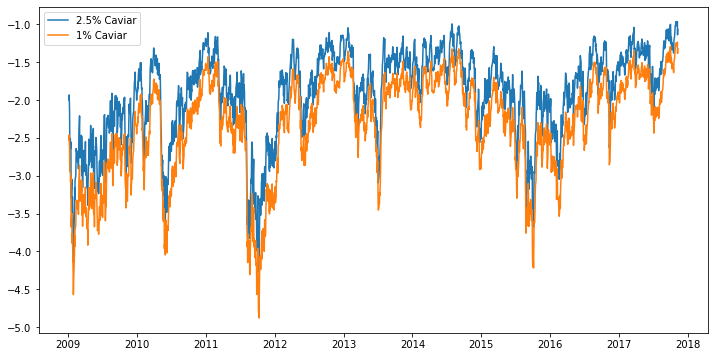

In [40]:
# Choose the estimates with the lowest quantile loss in each case.
var25_cav1 = caviar_est(caviar25_par1, r_ao[:last_in], 0.025, q025)
var25_cav = pd.Series(data = var25_cav1, index=r_ao[:last_in].index, dtype='float64')

var1_cav1 = caviar_est(caviar1_par3, r_ao[:last_in], 0.01, q01)
var1_cav = pd.Series(data = var1_cav1, index=r_ao[:last_in].index, dtype='float64')

plt.figure(figsize=(12, 6))
plt.plot(var25_cav, label='2.5% Caviar')
plt.plot(var1_cav, label='1% Caviar')

plt.legend()

plt.show()

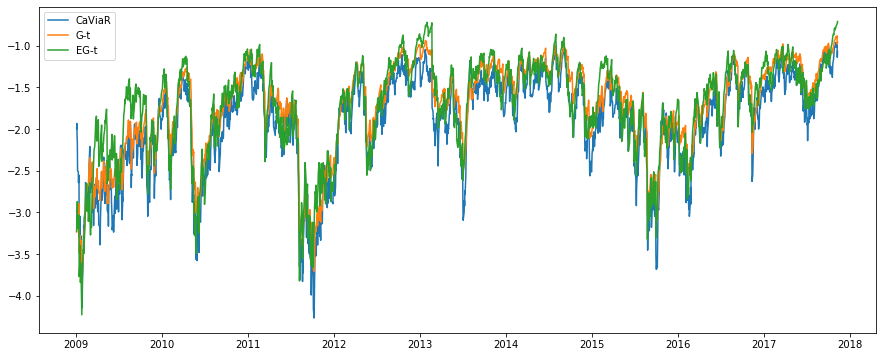

In [44]:
plt.figure(figsize=(15, 6))
plt.plot(var25_cav, label='CaViaR')
plt.plot(var25_gt, label='G-t')
plt.plot(var25_egt, label='EG-t')
plt.legend()
plt.show()

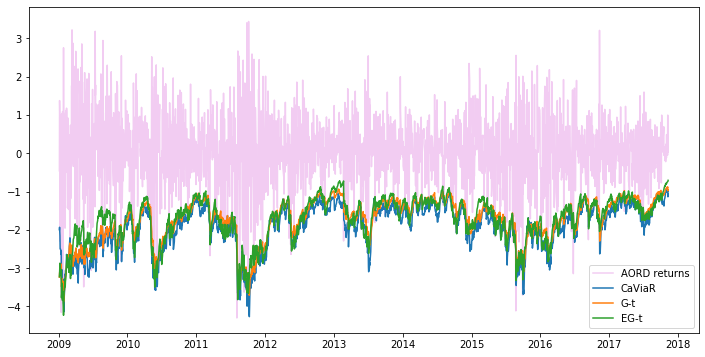

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(r_ao[:last_in], '-m', alpha=0.2, label='AORD returns')
plt.plot(var25_cav, label='CaViaR')
plt.plot(var25_gt, label='G-t')
plt.plot(var25_egt, label='EG-t')
plt.legend()
plt.show()

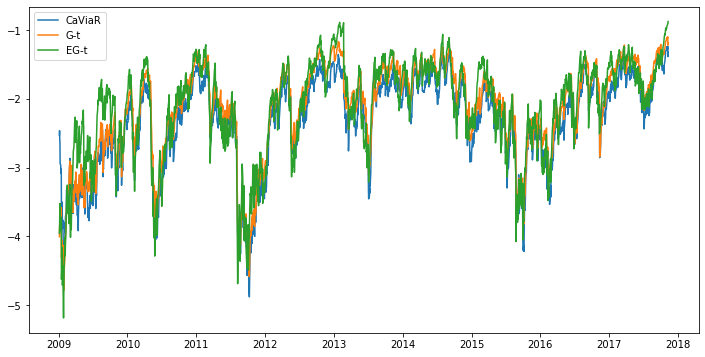

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(var1_cav, label='CaViaR')
plt.plot(var1_gt, label='G-t')
plt.plot(var1_egt, label='EG-t')
plt.legend()
plt.show()

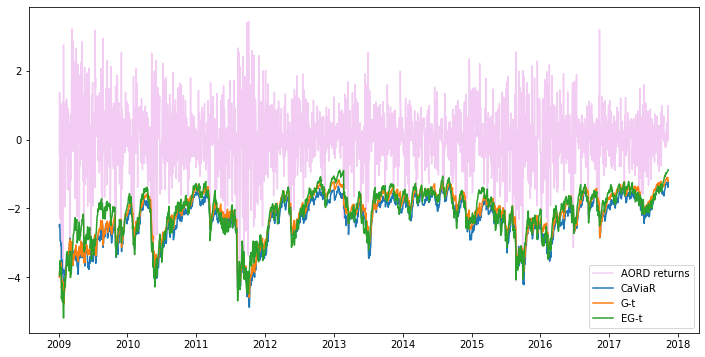

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(r_ao[:last_in], '-m', alpha=0.2, label='AORD returns')
plt.plot(var1_cav, label='CaViaR')
plt.plot(var1_gt, label='G-t')
plt.plot(var1_egt, label='EG-t')
plt.legend()
plt.show()

In [47]:
# Unconditional coverage test
def uctest(hit, a):
    n = len(hit)
    p = np.sum(hit) / n
    z = (p - a) / np.sqrt(a * (1 - a) / n)
    pval = 2 * stats.norm.sf(np.abs(z))
    return pval, p

# Independence test
def indtest(hits):
    n = len(hits)

    r5 = hits.values[1:]
    r51 = hits.values[:-1]
    i11 = r5*r51
    i01 = r5*(1-r51)
    i10 = (1-r5)*r51
    i00 = (1-r5)*(1-r51)

    t00 = np.sum(i00)
    t01 = np.sum(i01)
    t10 = np.sum(i10)
    t11 = np.sum(i11)
    p01 = t01/(t00+t01)
    p11 = t11/(t10+t11)
    p1 = (t01+t11)/n

    ll1 = t00 * np.log(1-p01) + (p01>0) * t01 * np.log(p01) + t10 * np.log(1-p11)
    if p11>0:
        ll1=ll1+t11*np.log(p11)
  
    ll0=(t10+t00)*np.log(1-p1)+(t01+t11)*np.log(p1)

    lrind=2*(ll1-ll0)
    pcc=1-stats.chi2.cdf(lrind,1)
    return pcc, lrind

# Dynamic quantile test
def dqtest(y,f,a,lag):
    n = len(y)
    hits = ((y<f)*1)*(1-a)
    hits = (hits)*1+(y>f)*(-a)
    q=2+lag
    
    if np.sum((y<f)*1) > 0:
        ns = n - lag
        xmat = np.column_stack([np.ones((ns,1)), f[lag:n+1]])
        for k in range(1,lag+1):
            lk = lag-k
            xmat = np.column_stack([xmat, hits[lk:n-k]])
    
        hx = np.dot((hits[lag:n+1]), xmat)
        xtx = np.linalg.lstsq(np.matmul(xmat.T, xmat), np.eye(q), rcond = None)[0]
        dq = np.dot(np.dot(hx, xtx), hx.T)
        dq = dq/(a*(1-a))
        pdq = 1 - stats.chi2.cdf(dq,q)
    else:
        pdq = np.nan
        dq = np.nan
    return pdq, dq

# Quantile loss function
def qloss(q,r,p):
    q = np.array(q)
    x1 = r[r > q]
    x2 = r[r < q]
    f1 = q[r > q]
    f2 = q[r < q]
    l = p * np.sum(x1-f1) + (1-p) * np.sum(f2-x2)
    return l

# Accuracy checks
def check_var_fc(var_fc, r, p):
    hit = r < var_fc
    n_hit = np.sum(hit)
    pval_uc, p_hat = uctest(hit, p)
    pval_ind = indtest(hit)[0]
    pval_dq = dqtest(r, var_fc, p, 4)[0]
    qtl_loss = qloss(var_fc, r, p)
    return [n_hit, p_hat, p_hat / p, pval_uc, pval_ind, pval_dq, qtl_loss]

In [48]:
# 2.5% Quantile Loss
qloss(var25_cav,r_ao[:last_in],0.025), qloss(var25_gt,r_ao[:last_in],0.025), qloss(var25_egt,r_ao[:last_in],0.025)

(133.48055455951663, 136.2497649734707, 130.79115554358737)

In [49]:
# 1% Quantile Loss
qloss(var1_cav,r_ao[:last_in],0.01), qloss(var1_gt,r_ao[:last_in],0.01), qloss(var1_egt,r_ao[:last_in],0.01)

(62.55002876024561, 62.846018058554165, 60.228517641277506)

### Answer guide
In terms of the quantile loss function, clearly the most accurate 1-day 2.5% and 1% VaR estimation model, in-sample, is the EGARCH-t model. The CaViaR and GARCH-t models are very similar to each other in loss function values. 

### (c) Calculate 1-day ahead forecasts at the 1st and 2.5th quantiles, updating parameters every 20 days, for each of the last 1000 days of the return data, using the models in (a) and (b), plus the same with Gaussian errors and the RiskMetrics model, all with a fixed estimation window size. Also include a 100 day sample percentile historical simulation forecast VaR method. You may add any, or your favourite, models/methods to the code below (which took 6.5 minuts on my laptop to run).

In [21]:
# One-day-ahead VaR forecasts, updating parameters every 20 days
n_fore = len(r_ao[frst_fc:])
var25_garch = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_garch = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var25_garch_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_garch_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var25_egarch = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_egarch = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var25_egarch_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_egarch_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var25_caviar = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_caviar = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var25_hs100 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_hs100 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var25_rm = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_rm = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

# Instantiate the GARCH-type model objects
arch = arch_model(r_ao, mean='Constant', vol='ARCH', p=5, dist='Normal')
arch_t = arch_model(r_ao, mean='Constant', vol='ARCH', p=5, dist='StudentsT')
garch = arch_model(r_ao, mean='Constant', vol='GARCH', p=1, q=1, dist='Normal')
garch_t = arch_model(r_ao, mean='Constant', vol='GARCH', p=1, q=1, dist='StudentsT')
egarch = arch_model(r_ao, mean='Constant', vol='EGARCH', p=1, o=1, q=1, dist='Normal')
egarch_t = arch_model(r_ao, mean='Constant', vol='EGARCH', p=1, o=1, q=1, dist='StudentsT')

n_wind = len(r_ao[:last_in])
for i in tqdm(range(n_fore)):
    if i % 20 == 0:
        garch_fit = garch.fit(first_obs=i, last_obs=i + n_wind, disp="off")
        garch_t_fit = garch_t.fit(first_obs=i, last_obs=i + n_wind, disp="off")
        egarch_fit = egarch.fit(first_obs=i, last_obs=i + n_wind, disp="off")
        egarch_t_fit = egarch_t.fit(first_obs=i, last_obs=i + n_wind, disp="off")
        q025 = np.quantile(r_ao[i:(i + n_wind)], 0.025)
        q01 = np.quantile(r_ao[i:(i + n_wind)], 0.01)
        caviar25_par = fmin(caviar_loss, x0=b02, args=(r_ao[i:(i + n_wind)], 0.025, q025), disp=False)
        caviar1_par = fmin(caviar_loss, x0=b02, args=(r_ao[i:(i + n_wind)], 0.01, q01), disp=False)
        v0 = np.var(r_ao[i:(i + n_wind)])
    
    # GARCH
    fc = garch_fit.forecast(horizon=1, align='target', reindex=False)
    temp25 = fc.mean + np.sqrt(fc.variance) * qn(0.025)
    temp1 = fc.mean + np.sqrt(fc.variance) * qn(0.01)
    var25_garch[i] = temp25.loc[var25_garch.index[i]]
    var1_garch[i] = temp1.loc[var1_garch.index[i]]
    # GARCH-t
    fc = garch_t_fit.forecast(horizon=1, align='target', reindex=False)
    temp25 = fc.mean + np.sqrt(fc.variance) * qt(0.025, garch_t_fit.params['nu'])
    temp1 = fc.mean + np.sqrt(fc.variance) * qt(0.01, garch_t_fit.params['nu'])
    var25_garch_t[i] = temp25.loc[var25_garch_t.index[i]]
    var1_garch_t[i] = temp1.loc[var1_garch_t.index[i]]
    # EGARCH
    fc = egarch_fit.forecast(horizon=1, align='target', reindex=False)
    temp25 = fc.mean + np.sqrt(fc.variance) * qn(0.025)
    temp1 = fc.mean + np.sqrt(fc.variance) * qn(0.01)
    var25_egarch[i] = temp25.loc[var25_egarch.index[i]]
    var1_egarch[i] = temp1.loc[var1_egarch.index[i]]
    # EGARCH-t
    fc = egarch_t_fit.forecast(horizon=1, align='target', reindex=False)
    temp25 = fc.mean + np.sqrt(fc.variance) * qt(0.025, egarch_t_fit.params['nu'])
    temp1 = fc.mean + np.sqrt(fc.variance) * qt(0.01, egarch_t_fit.params['nu'])
    var25_egarch_t[i] = temp25.loc[var25_egarch_t.index[i]]
    var1_egarch_t[i] = temp1.loc[var1_egarch_t.index[i]]
    # CaViaR
    temp25 = caviar_update(caviar25_par, r_ao, 0.025, q025)
    temp1 = caviar_update(caviar1_par, r_ao, 0.01, q01)
    var25_caviar[i] = temp25.loc[var25_caviar.index[i]]
    var1_caviar[i] = temp1.loc[var1_caviar.index[i]]
    # HS-100
    var25_hs100[i] = r_ao[(i + n_wind - 100):(i + n_wind)].quantile(0.025)
    var1_hs100[i] = r_ao[(i + n_wind - 100):(i + n_wind)].quantile(0.01)
    # RiskMetrics
    temp25 = np.sqrt(igarch_update(r_ao, v0)) * qn(0.025)
    temp1 = np.sqrt(igarch_update(r_ao, v0)) * qn(0.01)
    var25_rm[i] = temp25.loc[var25_rm.index[i]]
    var1_rm[i] = temp1.loc[var1_rm.index[i]]

  0%|          | 0/1000 [00:00<?, ?it/s]

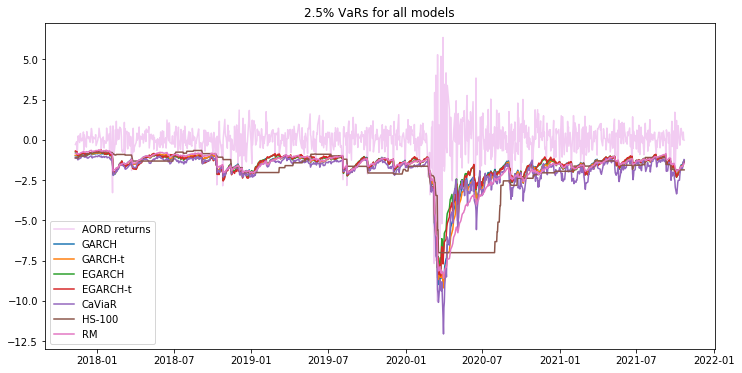

In [22]:
# 2.5% VaR forecasts
plt.figure(figsize=(12, 6))
plt.plot(r_ao[frst_fc:], '-m', alpha=0.2, label='AORD returns')
plt.plot(var25_garch, label='GARCH')
plt.plot(var25_garch_t, label='GARCH-t')
plt.plot(var25_egarch, label='EGARCH')
plt.plot(var25_egarch_t, label='EGARCH-t')
plt.plot(var25_caviar, label='CaViaR')
plt.plot(var25_hs100, label='HS-100')
plt.plot(var25_rm, label='RM')
plt.title('2.5% VaRs for all models')
plt.legend()
plt.show()

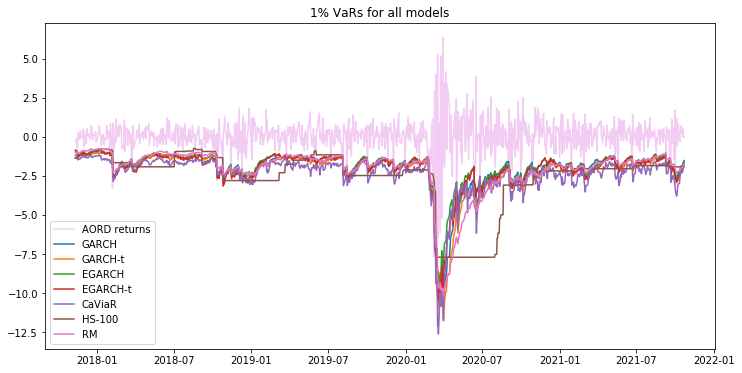

In [23]:
# 1% VaR forecasts
plt.figure(figsize=(12, 6))
plt.plot(r_ao[frst_fc:], '-m', alpha=0.2, label='AORD returns')
plt.plot(var1_garch, label='GARCH')
plt.plot(var1_garch_t, label='GARCH-t')
plt.plot(var1_egarch, label='EGARCH')
plt.plot(var1_egarch_t, label='EGARCH-t')
plt.plot(var1_caviar, label='CaViaR')
plt.plot(var1_hs100, label='HS-100')
plt.plot(var1_rm, label='RM')
plt.title('1% VaRs for all models')
plt.legend()
plt.show()

#### (d) Assess the accuracy and independence and loss function values of the models at forecasting the 2.5th and 1st quantiles for the All Ordinaries Index.

In [24]:
# Violations (hits)
hit25_garch = r_ao[frst_fc:] < var25_garch
hit1_garch = r_ao[frst_fc:] < var1_garch
hit25_garch_t = r_ao[frst_fc:] < var25_garch_t
hit1_garch_t = r_ao[frst_fc:] < var1_garch_t
hit25_egarch = r_ao[frst_fc:] < var25_egarch
hit1_egarch = r_ao[frst_fc:] < var1_egarch
hit25_egarch_t = r_ao[frst_fc:] < var25_egarch_t
hit1_egarch_t = r_ao[frst_fc:] < var1_egarch_t
hit25_caviar = r_ao[frst_fc:] < var25_caviar
hit1_caviar = r_ao[frst_fc:] < var1_caviar
hit25_hs100 = r_ao[frst_fc:] < var25_hs100
hit1_hs100 = r_ao[frst_fc:] < var1_hs100
hit25_rm = r_ao[frst_fc:] < var25_rm
hit1_rm = r_ao[frst_fc:] < var1_rm

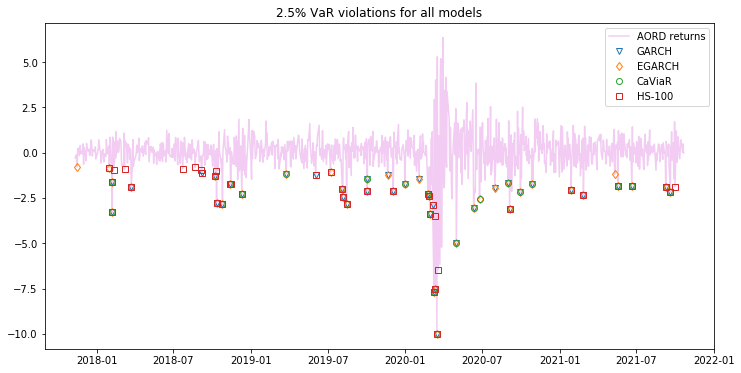

In [25]:
# 2.5% VaR violations
plt.figure(figsize=(12, 6))
plt.plot(r_ao[frst_fc:], '-m', alpha=0.2, label='AORD returns')
plt.plot(r_ao[frst_fc:][hit25_garch], 'v', mfc='none', label='GARCH')
plt.plot(r_ao[frst_fc:][hit25_egarch], 'd', mfc='none', label='EGARCH')
plt.plot(r_ao[frst_fc:][hit25_caviar], 'o', mfc='none', label='CaViaR')
plt.plot(r_ao[frst_fc:][hit25_hs100], 's', mfc='none', label='HS-100')
plt.title('2.5% VaR violations for all models')
plt.legend()
plt.show()

In [26]:
# Unconditional coverage test
def uctest(hit, a):
    n = len(hit)
    p = np.sum(hit) / n
    z = (p - a) / np.sqrt(a * (1 - a) / n)
    pval = 2 * stats.norm.sf(np.abs(z))
    return pval, p

# Independence test
def indtest(hits):
    n = len(hits)

    r5 = hits.values[1:]
    r51 = hits.values[:-1]
    i11 = r5*r51
    i01 = r5*(1-r51)
    i10 = (1-r5)*r51
    i00 = (1-r5)*(1-r51)

    t00 = np.sum(i00)
    t01 = np.sum(i01)
    t10 = np.sum(i10)
    t11 = np.sum(i11)
    p01 = t01/(t00+t01)
    p11 = t11/(t10+t11)
    p1 = (t01+t11)/n

    ll1 = t00 * np.log(1-p01) + (p01>0) * t01 * np.log(p01) + t10 * np.log(1-p11)
    if p11>0:
        ll1=ll1+t11*np.log(p11)
  
    ll0=(t10+t00)*np.log(1-p1)+(t01+t11)*np.log(p1)

    lrind=2*(ll1-ll0)
    pcc=1-stats.chi2.cdf(lrind,1)
    return pcc, lrind

# Dynamic quantile test
def dqtest(y,f,a,lag):
    n = len(y)
    hits = ((y<f)*1)*(1-a)
    hits = (hits)*1+(y>f)*(-a)
    q=2+lag
    
    if np.sum((y<f)*1) > 0:
        ns = n - lag
        xmat = np.column_stack([np.ones((ns,1)), f[lag:n+1]])
        for k in range(1,lag+1):
            lk = lag-k
            xmat = np.column_stack([xmat, hits[lk:n-k]])
    
        hx = np.dot((hits[lag:n+1]), xmat)
        xtx = np.linalg.lstsq(np.matmul(xmat.T, xmat), np.eye(q), rcond = None)[0]
        dq = np.dot(np.dot(hx, xtx), hx.T)
        dq = dq/(a*(1-a))
        pdq = 1 - stats.chi2.cdf(dq,q)
    else:
        pdq = np.nan
        dq = np.nan
    return pdq, dq

# Quantile loss function
def qloss(q,r,p):
    q = np.array(q)
    x1 = r[r > q]
    x2 = r[r < q]
    f1 = q[r > q]
    f2 = q[r < q]
    l = p * np.sum(x1-f1) + (1-p) * np.sum(f2-x2)
    return l

# Accuracy checks
def check_var_fc(var_fc, r, p):
    hit = r < var_fc
    n_hit = np.sum(hit)
    pval_uc, p_hat = uctest(hit, p)
    pval_ind = indtest(hit)[0]
    pval_dq = dqtest(r, var_fc, p, 4)[0]
    qtl_loss = qloss(var_fc, r, p)
    return [n_hit, p_hat, p_hat / p, pval_uc, pval_ind, pval_dq, qtl_loss]

In [27]:
# 2.5% VaR forecast accuracy checks
tbl_var25 = pd.DataFrame({
    'G-N': check_var_fc(var25_garch, r_ao[frst_fc:], 0.025),
    'EG-N': check_var_fc(var25_egarch, r_ao[frst_fc:], 0.025),
    'G-t': check_var_fc(var25_garch_t, r_ao[frst_fc:], 0.025),
    'EG-t': check_var_fc(var25_egarch_t, r_ao[frst_fc:], 0.025),
    'CaViaR': check_var_fc(var25_caviar, r_ao[frst_fc:], 0.025),
    'HS100': check_var_fc(var25_hs100, r_ao[frst_fc:], 0.025),
    'IGARCH': check_var_fc(var25_rm, r_ao[frst_fc:], 0.025)},
    index=['Viol. (25)', '$\hat{p}$', '$\hat{p}/p$', 'UC', 'Ind', 'DQ', 'Loss']
)
tbl_var25.round(4)

,G-N,EG-N,G-t,EG-t,CaViaR,HS100,IGARCH
Viol. (25),40.0000,42.0000,41.0000,45.0000,35.0000,41.0000,39.0000
$\hat{p}$,0.0400,0.0420,0.0410,0.0450,0.0350,0.0410,0.0390
$\hat{p}/p$,1.6000,1.6800,1.6400,1.8000,1.4000,1.6400,1.5600
UC,0.0024,0.0006,0.0012,0.0001,0.0428,0.0012,0.0046
Ind,0.0921,0.3741,0.1084,0.5015,0.1559,0.0010,0.0005
DQ,0.0044,0.0162,0.0021,0.0064,0.0213,0.0000,0.0000
Loss,78.3467,76.9636,78.6237,76.9515,77.1301,93.3782,80.0698


#### Answer guide
For 1-day-ahead VaR 2.5% forecasting for AORD returns, the CaViar model had the most accurate violation rate of 0.035, thogh this was still 40% above the desired 0.025. All models failed the UC test, i.e. all models had violation rates significantly different (clearly higher) than 0.025. All models also failed the DQ test, indicating their violations are also correlated over time. The violations plot below shows some clear clustering of all models violations, especially in early 2018, mid-2019 and early 2020.

The loss function results favoured the EGARCH-t, EGARCH-N and CaViar models, in that order. 

All models tried can be rejected here!

I would suggest to add the GJR-t model as potentially better model. We will also add SP500 as a regressor in Tutorial 13 to see if that improves things for the AORD.

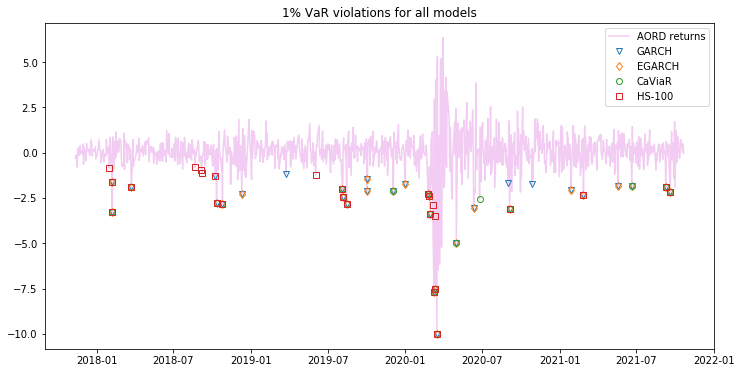

In [28]:
# 1% VaR violations
plt.figure(figsize=(12, 6))
plt.plot(r_ao[frst_fc:], '-m', alpha=0.2, label='AORD returns')
plt.plot(r_ao[frst_fc:][hit1_garch], 'v', mfc='none', label='GARCH')
plt.plot(r_ao[frst_fc:][hit1_egarch], 'd', mfc='none', label='EGARCH')
plt.plot(r_ao[frst_fc:][hit1_caviar], 'o', mfc='none', label='CaViaR')
plt.plot(r_ao[frst_fc:][hit1_hs100], 's', mfc='none', label='HS-100')
plt.title('1% VaR violations for all models')
plt.legend()
plt.show()

In [29]:
# 1% VaR forecast accuracy checks
tbl_var1 = pd.DataFrame({
    'G-N': check_var_fc(var1_garch, r_ao[frst_fc:], 0.01),
    'EG-N': check_var_fc(var1_egarch, r_ao[frst_fc:], 0.01),
    'G-t': check_var_fc(var1_garch_t, r_ao[frst_fc:], 0.01),
    'EG-t': check_var_fc(var1_egarch_t, r_ao[frst_fc:], 0.01),
    'CaViaR': check_var_fc(var1_caviar, r_ao[frst_fc:], 0.01),
    'HS100': check_var_fc(var1_hs100, r_ao[frst_fc:], 0.01),
    'IGARCH': check_var_fc(var1_rm, r_ao[frst_fc:], 0.01)},
    index=['Viol. (10)', '$\hat{p}$', '$\hat{p}/p$', 'UC', 'Ind', 'DQ', 'Loss']
)
tbl_var1.round(4)

,G-N,EG-N,G-t,EG-t,CaViaR,HS100,IGARCH
Viol. (10),32.0000,28.0000,27.0000,27.0000,19.0000,26.0000,30.0000
$\hat{p}$,0.0320,0.0280,0.0270,0.0270,0.0190,0.0260,0.0300
$\hat{p}/p$,3.2000,2.8000,2.7000,2.7000,1.9000,2.6000,3.0000
UC,0.0000,0.0000,0.0000,0.0000,0.0042,0.0000,0.0000
Ind,0.0970,0.0457,0.2032,0.0370,0.3701,0.0003,0.0678
DQ,0.0000,0.0000,0.0000,0.0000,0.0035,0.0000,0.0000
Loss,43.8591,43.5346,41.4872,41.2833,34.9935,51.0422,46.6706


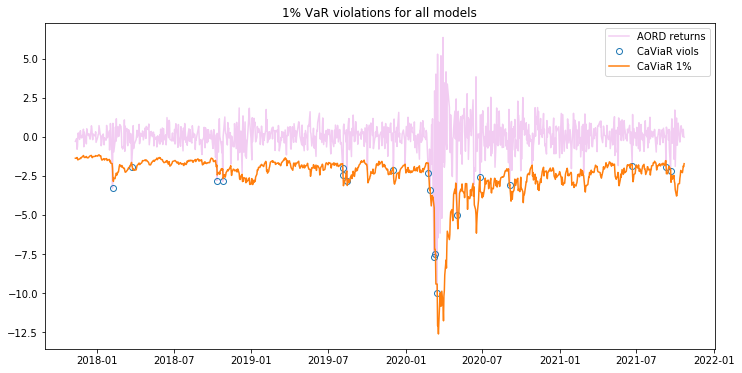

In [30]:
# 1% VaR violations
plt.figure(figsize=(12, 6))
plt.plot(r_ao[frst_fc:], '-m', alpha=0.2, label='AORD returns')
plt.plot(r_ao[frst_fc:][hit1_caviar], 'o', mfc='none', label='CaViaR viols')
plt.plot(var1_caviar, label='CaViaR 1%')
plt.title('1% VaR violations for all models')
plt.legend()
plt.show()

#### Answer guide
For 1-day-ahead VaR 1% forecasting for AORD returns, the CaViar model again has the most accurate violation rate of 0.019, though this was still 90% above the desired 0.01. All models again failed the UC test, i.e. all models had violation rates significantly different (clearly higher) than 0.01. All models again also failed the DQ test, indicating their violations are also correlated over time. The violations plot above shows some clear clustering of the CaViar model 1% violations, especially in mid-2019 and early 2020.

The loss function results clearly favoured the CaViar model only. 

All models tried can be rejected here!

I would suggest to add the GJR-t model as a potentially better model. We will also add SP500 as a regressor in Tutorial 13 to see if that improves things for the AORD VaR forecasting!